C:\Users\ayush\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py:3672: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\ayush\AppData\Local\Temp\ipykernel_19592\718778269.py:24: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instea

C:\Users\ayush\AppData\Local\Temp\ipykernel_19592\718778269.py:27: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


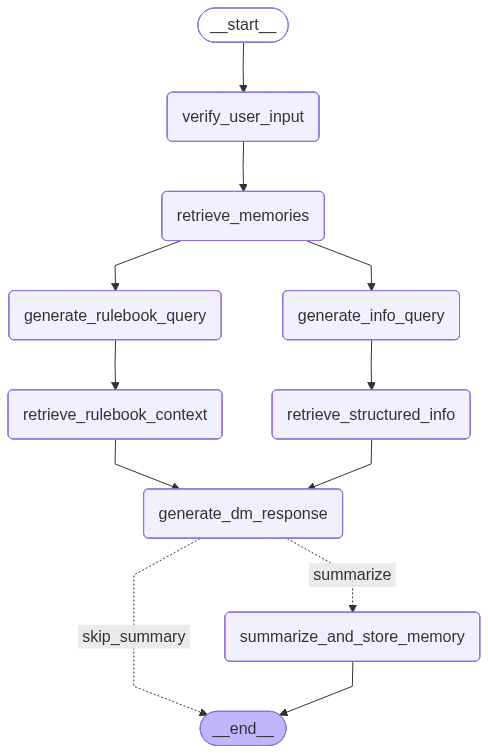

In [ ]:
import os
import chromadb
from typing import TypedDict, Annotated, List, Sequence
from collections import deque # NEW: Import deque for short-term memory
from langchain_core.pydantic_v1 import BaseModel
from dotenv import load_dotenv
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser # Corrected import
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages

# --- 1. Setup Environment ---
# load_dotenv()
# os.environ["GROQ_API_KEY"]="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"
from langchain_openai import ChatOpenAI # MODIFIED: Import ChatOpenAI

# MODIFIED: Point to the local LM Studio server
llm = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    api_key="meta-llama-3-8b-instruct", # API key is not required for local server
    temperature=0.7,      # Set your desired temperature
)

embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# --- 2. Persistent Vector Store Setup (Long-Term Memory) ---
vectorstore = Chroma(
    collection_name="long_term_context_4",
    embedding_function=embedding_function,
    persist_directory="./Test11"
)
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

rulebook_vectorstore = Chroma(
    collection_name="dnd_manual",
    embedding_function=embedding_function,
    persist_directory="./dm_rulebook_db"
)
rulebook_retriever = rulebook_vectorstore.as_retriever(search_kwargs={"k": 4})

info_vectorstore = Chroma(
    collection_name="dnd_structured_info",
    embedding_function=embedding_function,
    persist_directory="./dm_info_db" # The new DB directory
)
info_retriever = info_vectorstore.as_retriever(search_kwargs={"k": 4})
# --- 3. Graph State ---
class GameState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    turn_number: int
    documents: List[str]
    search_query: str
    short_term_memory: deque 
   
    rulebook_query: str

    rulebook_context: List[str]
    info_query: str               
    structured_info: List[str]
# --- 4. Graph Nodes ---

def retrieve_memories(state: GameState) -> GameState:
    print("---NODE: RETRIEVE MEMORIES---")
    player_input = state["messages"][-1].content
    print(f"---Player Input: {player_input}---")
    docs = retriever.invoke(player_input)
    retrieved_docs_text = [doc.page_content for doc in docs]
    return {"documents": retrieved_docs_text, "search_query": player_input}



def verify_user_input(state: GameState) -> GameState:
    """
    Enhanced context-aware verifier:
    Uses both short-term and long-term memory to decide whether
    the player's latest input fits the story, scene, and emotional tone.
    """

    print("---NODE: VERIFY USER INPUT (Context-Aware)---")

    player_input = state["messages"][-1].content

    # Retrieve contextual memories
    short_term_context = "\n".join(state["short_term_memory"]) if state.get("short_term_memory") else "No short-term memory available."
    long_term_context = "\n".join(state["documents"]) if state.get("documents") else "No long-term memory available."

    # Construct a refined reasoning prompt
    prompt = ChatPromptTemplate.from_template(
"""
You are a **Friendly and Intelligent RPG Input Moderator** for a text-based fantasy adventure.

 **Your mission:**
Help the player express what they mean — even if their input is short, contains typos, slang, or unpolished grammar.
Encourage creativity and spontaneity.
Only block or rewrite messages that make absolutely *no sense* in the story world.

If the player says **"quit"**, **"exit"**, or **"end game"**, treat that as a valid and relevant action to end the game session gracefully.

You have access to both:
- **Short-Term Memory** – recent events, dialogue, or actions.
-  **Long-Term Memory** – world details, past places, and known entities.

---
 SHORT-TERM MEMORY:
{short_term_context}

 LONG-TERM MEMORY:
{long_term_context}

 PLAYER INPUT:
"{player_input}"
---

###  INSTRUCTIONS:

1. **Be forgiving with typos or grammar.**
   - Try to infer what the player *intended* to say.
   - Example:
     - "I go nort" → "I go north"
     - "talk 2 gard" → "talk to the guard"

2. **Encourage simplicity.**
   - Short or vague commands like “look around”, “go ahead”, “keep walking”, “open the door” are all valid.

3. **Accept exit actions.**
   - Inputs like “quit”, “exit”, “end game”, or “leave the adventure” should be treated as relevant and meaningful.

4. **Reject only nonsense or out-of-world text.**
   - Ignore things like random gibberish (“asdfgh”), off-topic chat (“open Chrome”), or technical questions (“what’s your GPU?”).

5. **Use context to decide fit.**
   - Check if the action makes sense given the current location, mood, or world rules.
   - Maintain emotional tone consistency — serious scenes stay serious, unless player humor fits the moment.

6. **If input is unclear but possibly meaningful, rewrite it softly.**
   - Never shame or block the player — instead, correct and adapt the message naturally.

---

###  HOW TO DECIDE

- If the input makes sense after small fixes →  *ACCEPT* it. 
- If it’s completely irrelevant →  *REWRITE* it and explain briefly why.  
- If it’s “quit”, “exit”, or “end game” →  *ACCEPT* as valid.

---

###  RESPONSE FORMAT:

Decision: [ACCEPT or REWRITE]
Reason: [Brief explanation — why it fits or not]
Corrected Input: [If spelling or grammar was fixed, show the corrected version]
Suggested Rewrite: [If REWRITE, provide a short, immersive rewrite that fits the current context]
---
"""
)

    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({
        "player_input": player_input,
        "short_term_context": short_term_context,
        "long_term_context": long_term_context
    })

    # print(f"---Raw LLM Response---\n{response}\n----------------------")

    # Extract results safely
    decision, reason, suggested = "accept", "", player_input
    for line in response.splitlines():
        line = line.strip()
        if line.lower().startswith("decision:"):
            decision = line.split(":", 1)[1].strip().lower()
        elif line.lower().startswith("reason:"):
            reason = line.split(":", 1)[1].strip()
        elif line.lower().startswith("suggested rewrite:"):
            suggested = line.split(":", 1)[1].strip()

    # Handle based on decision
    if "rewrite" in decision:
        print(f"---DECISION: REWRITE---\nReason: {reason}\nSuggested: {suggested}")
        inp=input("The prompt is out of context write again")
        
        state["messages"][-1] = HumanMessage(content=inp)
        verify_user_input(state)
        # state["short_term_memory"].append(f"Rewritten input: {suggested}")
    else:
        print(f"---DECISION: ACCEPT---\n")
        # state["short_term_memory"].append(f"Accepted input: {player_input}")

    return {}


def generate_rulebook_query(state: GameState) -> GameState:
    """Node 2 (NEW): Synthesize context to create a targeted query for the rulebook."""
    print("---NODE: GENERATE RULEBOOK QUERY---")
    
    prompt = ChatPromptTemplate.from_template(
    """You are a Strategic Query Crafter for an AI Dungeon Master. Your purpose is to generate a detailed search query for a D&D manual to retrieve information that will both ensure rule adherence and inspire creative storytelling.

    Your process should be:
    1.  **Identify Core Mechanics:** Extract any explicit game terms from the player's action (spell names, skills, character abilities, combat actions).
    2.  **Identify Thematic Elements:** Look for broader concepts in the context (creatures, locations, character classes, items) that could be enriched with lore or descriptive details from the manual.
    3.  **Synthesize for Storytelling (Crucial):** Combine the mechanical and thematic elements into a single query. Actively seek information that would make the scene more vivid, the characters' actions more meaningful, and the world more alive.

    **Example 1:**
    -   **Context:** A player says, "I cast Magic Missile at the lead goblin!"
    -   **Generated Query:** `Magic Missile spell description, rules for spell targeting, goblin monster description, visual effects of evocation magic`
    
    **Example 2:**
    -   **Context:** A Paladin player says, "I try to intimidate the captured orc." Past events show the party is deep in a dwarven ruin.
    -   **Generated Query:** `Intimidation skill rules, orc monster description, Paladin class abilities, divine presence, dwarven ruin architecture, racial animosity between orcs and dwarves`
    
    ---
    Now, based on the following context, generate the best possible query.
    
    -   **Player's Immediate Action:** "{player_input}"
    -   **Recent Conversation:** {short_term_memory}
    -   **Relevant Past Events:** {story_context}
    IN YOUR FINAL OUTPUT ONLY INCLUDE THE FINAL GENERATED QUERY, DO NOT INCLUDE ANY OTHER TEXT-> 
    Generated Query:"""
    )
    
    chain = prompt | llm | StrOutputParser()
    
    player_input = state["messages"][-1].content
    short_term_memory = "\n".join(state["short_term_memory"])
    story_context = "\n".join(state["documents"]) if state.get("documents") else "No relevant long-term memories found."
    
    query = chain.invoke({
        "player_input": player_input,
        "short_term_memory": short_term_memory,
        "story_context": story_context
    })
    
    # print(f"---Generated Rulebook Query: {query}---")
    return {"rulebook_query": query}

def retrieve_rulebook_context(state: GameState) -> GameState:
    """Node 3 (NEW): Retrieve documents from the rulebook DB using the generated query."""
    print("---NODE: RETRIEVE RULEBOOK CONTEXT---")
    rule_docs = rulebook_retriever.invoke(state["rulebook_query"])
    # print(f"---Retrieved rulebook documents {[doc.page_content for doc in rule_docs]} .---")
    return {"rulebook_context": [doc.page_content for doc in rule_docs]}

def generate_info_query(state: GameState) -> GameState:
    """NEW Node 2: Creates a targeted query for the dm_info_db."""
    print("---NODE: GENERATE INFO QUERY---")
    prompt = ChatPromptTemplate.from_template(
        """You are a database query assistant for a D&D game. Your task is to extract the primary noun from the player's input that likely corresponds to a specific **monster, spell, item, or race**.
        Also **extract** some random spells monsters items and bring pcharacters of different to make the story more engaging and interesting
        
        Generate a concise query designed to look up this specific entity in a database.
        
        Example 1:
        - Player Input: "I attack the Aboleth with my sword!"
        - Generated Query: "Aboleth,spells,monsters,elf"

        Example 2:
        - Player Input: "I want to cast Fireball on the group of orcs."
        - Generated Query: "Fireball spell,*other random things to make good story*"

        Player Input: "{player_input}"
        Generated Query:"""
    )
    chain = prompt | llm | StrOutputParser()
    query = chain.invoke({"player_input": state["messages"][-1].content})
    # print(f"---Generated Info Query: {query}---")
    return {"info_query": query}

# NEW: Node to retrieve from the structured data DB
def retrieve_structured_info(state: GameState) -> GameState:
    """NEW Node 3: Retrieves info from dm_info_db using the generated query."""
    print("---NODE: RETRIEVE STRUCTURED INFO---")
    info_docs = info_retriever.invoke(state["info_query"])
    return {"structured_info": [doc.page_content for doc in info_docs]}
    

def generate_dm_response(state: GameState) -> GameState:
    """
    MODIFIED: This node now uses both short-term and long-term memory.
    """
    print("---NODE: GENERATE DM RESPONSE---")

    prompt = ChatPromptTemplate.from_messages([
    ("system",
     """
You are a master storyteller and Dungeon Master (DM) guiding a fantasy adventure.
Your mission is to narrate vivid, immersive scenes that feel alive — like a cinematic story unfolding turn by turn.

📜 *Tone and Style Guidelines:*
- Write in short, easy-to-read paragraphs (2–4 sentences each).
- Use sensory details — describe sounds, light, movement, or atmosphere.
- Make each turn feel alive with emotion, tension, or mystery.
- End with a subtle hook or prompt that invites the player to respond freely.
- DO NOT give explicit numbered options or choices.

 *How to Use Your Knowledge:*
 -Use  for facts in the **[Structured Data]**. Use it for extra details about monsters, spells, items, and races (e.g., Armor Class, damage, abilities) to make the story more compelling .
 -Use some of these extracted info abouts spells monsters items and characters to make the story more engaging and interesting.
- Your narration must be **inspired by the lore** and **from by the rules** found in the [Rulebook/Guidance] context.
- Weave these rules and descriptions seamlessly into your storytelling. Don't just state a rule; describe its effect on the world.
- Maintain **story continuity** by referencing events from the [Story Context] and [Short-Term Memory].
- If the retrieved context is empty or irrelevant, rely on your general knowledge and creativity to move the story forward.
- Make a good use of other npc characters to make a engaging story
-construct the story like th estory of dungeon and dragons with rich details and immersive world-building and good character building
-Build characters that have depth and complexity, with their own motivations, fears, and desires,special powers and more.

******************* END YOUR RESPONSE with a section clearly labeled:
         '--- SUMMARY FOR PLAYER ---'
         In this section, write 3–5 bullet points summarizing:
         - Key new events or discoveries
         - Immediate threats, clues, or decisions
         - Next possible actions or directions the player can take

         Example format:
         ---
         The skeleton’s blade gleams as it lunges forward, the torchlight flickering against the crypt walls.
         Your breath forms clouds in the cold air as a distant wail echoes through the darkness.

         --- SUMMARY FOR PLAYER ---
         • You are fighting one skeleton; one more shadow moves nearby.
         • Your torchlight is fading fast.
         • You can: attack, dodge, use an item, or retreat toward the staircase.
         ---
Use the following context to guide the story:

1️ *Short-Term Memory (The immediate back-and-forth):*
{short_term_memory}

2️ *Story Context (Relevant past events from this adventure):*
{long_term_context}
 *Structured Data (Specific stats & facts for monsters, spells, etc.):*
{structured_info}
3️ *Rulebook/Guidance (The laws of the world, lore, and mechanics):*
{rulebook_context}

Now, based on the player's latest action, continue the story in a way that is exciting, cinematic, and true to the rules.
"""),
    MessagesPlaceholder(variable_name="messages"),
])
    


    chain = prompt | llm_2 | StrOutputParser()

    long_term_context = "\n".join(state["documents"]) if state["documents"] else "No relevant long-term memories found."

    # NEW: Format the short-term memory deque into a readable string.
    short_term_context = "\n".join(state["short_term_memory"]) if state["short_term_memory"] else "This is the start of the conversation."
    print(f"---Short-Term Context:\n{short_term_context}---")
    print(f"---Long-Term Context:\n{long_term_context}---")
    dm_response_text = chain.invoke({
        "messages": state["messages"],
        "structured_info": "\n".join(state["structured_info"]),
        "rulebook_context": "\n".join(state["rulebook_context"]),
        "long_term_context": long_term_context,
        "short_term_memory": short_term_context
    })

    dm_response_message = AIMessage(content=dm_response_text)
    # print(f"---DM Response: {dm_response_text}---")
    return {"messages": [dm_response_message]}


def summarize_and_store_memory(state: GameState) -> GameState:
    print("---NODE: SUMMARIZE AND STORE MEMORY---")
    last_turn_messages = state["messages"][-1].content
    inp = state["messages"][-2].content
    # print(f"---Last Turn Messages: {last_turn_messages}---")
    # print(f"---User Input: {inp}---")
    summarization_prompt = ChatPromptTemplate.from_messages([
        ("system",
         """
You are an expert story archivist for a fantasy role-playing adventure.
Your task is to extract and store *only the key details* from this turn of the story.

 *Goal:* Summarize the player's action and the DM's response
into clear, compact bullet points — not full sentences.

 *Instructions:*
- Use a *clean bullet-point list* format.
- Include important *names, places, objects, and actions*.
- Highlight newly introduced or significant information using *UPPERCASE* or *⚡ symbols*.
- Keep older or less important details brief and lowercase.
- Avoid unnecessary narration or filler text.

 *Input:* {inp}
 *DM Response:* {last_turn_messages}

Now, extract all relevant story keywords, actions, character abilities ,their powers ,their fears ,special points and new entities as bullet points.
Example output format:

-  NEW CHARACTER: Seraphine, a rogue mage
- sERAPHINE SPECIAL POWER: tHROW FIREBALL
- LOCATION: The Shattered Bridge (collapsed)
- ACTION: Player inspected a glowing rune
- ITEM: Ancient dagger found
- MOOD: tense, cautious
- MINOR DETAIL: torches flickered
""")
    ])
    summarization_chain = summarization_prompt | llm | StrOutputParser()
    summary = summarization_chain.invoke({"last_turn_messages": last_turn_messages, "inp": inp})
    print(f"---Saving Summary: {summary}---")
    # A.append(summary) # Removed unused variable 'A'
    vectorstore.add_texts(texts=[summary], metadatas=[{"turn": state["turn_number"]}])
    # b.append(summary)
    return {}


def should_summarize(state: GameState) -> str:
    """
    DECIDES whether the current turn should be summarized based on its significance.
    """
    print("---EDGE: SHOULD SUMMARIZE?---")

    last_turn_messages = state["messages"][-2:]
    
    # Use story_context (renamed from documents) for long-term memory
    short_term_context = (
        "\n".join(state["short_term_memory"])
        if state.get("short_term_memory")
        else "No relevant short-term memories retrieved."
    )
    
    # --- MODIFIED: New, simpler prompt ---
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         """
        You are a Story Significance Analyzer. Your job is to decide if the latest turn in a story is important enough to be saved to long-term memory.

        Analyze the current interaction in the context of past events.
        
        - **SUMMARIZE IF:** The turn introduces a new character, item, location, or quest; reveals a crucial piece of information; or results in a significant plot development.
        - **SKIP IF:** The turn consists of routine actions (e.g., walking down an empty hallway), simple descriptions of things already known, or filler conversation.

        ---
        PAST STORY CONTEXT:
        {short_term_context}

        CURRENT INTERACTION:
        {last_turn_messages}
        ---

        Is this interaction significant enough to be recorded for future reference?
        Respond with only one of two words: **SUMMARIZE** or **SKIP**.
        """)
    ])

    chain = prompt | llm | StrOutputParser()
    
    decision = chain.invoke({
        "last_turn_messages": last_turn_messages,
        "short_term_context": short_term_context
    })

    # --- MODIFIED: Corrected decision logic ---
    if "SUMMARIZE" in decision.upper():
        print("---DECISION: YES → SUMMARIZE---")
        return "summarize"
    else:
        print("---DECISION: NO → SKIP SUMMARY---")
        return "skip_summary"

workflow = StateGraph(GameState)
workflow.add_node("retrieve_memories", retrieve_memories)
workflow.add_node("verify_user_input", verify_user_input)
workflow.add_node("generate_info_query", generate_info_query)
workflow.add_node("retrieve_structured_info", retrieve_structured_info)
workflow.add_node("generate_rulebook_query", generate_rulebook_query)
workflow.add_node("retrieve_rulebook_context", retrieve_rulebook_context)
workflow.add_node("generate_dm_response", generate_dm_response)
workflow.add_node("summarize_and_store_memory", summarize_and_store_memory)

workflow.add_edge(START, "verify_user_input")
workflow.add_edge("verify_user_input","retrieve_memories")
# workflow.add_edge("retrieve_memories","verify_user_input")


workflow.add_edge("retrieve_memories", "generate_rulebook_query")
workflow.add_edge("retrieve_memories", "generate_info_query")

workflow.add_edge("generate_rulebook_query", "retrieve_rulebook_context")
workflow.add_edge("generate_info_query", "retrieve_structured_info")
# workflow.add_edge("retrieve_rulebook_context", "generate_dm_response")
workflow.add_edge("retrieve_structured_info", "generate_dm_response")
workflow.add_edge("retrieve_rulebook_context", "generate_dm_response")
# workflow.add_edge( "generate_dm_response","summarize_and_store_memory")

# workflow.add_edge("retrieve_memories", "generate_dm_response")
# workflow.add_edge("generate_dm_response", "summarize_and_store_memory")

workflow.add_conditional_edges(
    "generate_dm_response",
    should_summarize,
    {"summarize": "summarize_and_store_memory", "skip_summary": END}
)
workflow.add_edge("summarize_and_store_memory", END)
app = workflow.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))
# --- 7. Main Game Loop ---

In [ ]:
if __name__ == "__main__":
    print("AI Dungeon Master Initialized (Agentic RAG + Short-Term Memory).")

    # Initialize the game state with short-term memory deque.
    game_state = {
        "messages": [SystemMessage(content=(
            "You are the Dungeon Master of a highly immersive, cinematic fantasy adventure inspired by Dungeons & Dragons. "
            "Your role is to narrate the world vividly, describe environments in sensory detail, manage NPCs and monsters, and respond logically to player actions. "
            "Maintain world consistency, evolving consequences, and continuity using short-term and long-term memory.\n\n"
            
            "=== CHARACTER INTRODUCTION ===\n"
            "The player is Thrain Stonehelm — a battle-hardened dwarf warrior from the Frosthammer Clan. "
            "He wields a massive battle axe engraved with runes that pulse faintly when danger is near. "
            "Thrain also possesses a rare magical ability: the spell Animal Shapes, which can transform creatures and beings into beasts of his choosing. "
            "He is resourceful, sharp-eyed, and resilient, accustomed to navigating treacherous terrain and confronting mystical threats.\n\n"
            
            "=== STORY BEGINNING ===\n"
            "Twilight descends over the jagged cliffs of Eldoria. Rain falls in cold, stinging sheets, soaking the earth and carrying the scent of wet stone and moss. "
            "Thrain stands before the Shadowspire Dungeon, a massive stone fortress carved into the mountainside, partially shrouded in fog. "
            "The iron doors bear glowing amber runes that flicker like molten veins.\n\n"
            
            "To his left lies a crumbling watchtower, its roof collapsed and walls overtaken by vines. "
            "To his right, a ravine glows faintly orange, hinting at firelight or something else hidden in the mist. "
            "Nearby, a large wooden crate bound with rusted iron sits half-buried in mud and roots. The lid shifts slightly as if something moves inside. "
            "A crow perches on a stone nearby, watching silently, while distant thunder rumbles across the mountains.\n\n"
            "Thrain’s battle axe hums faintly, and his magical senses tingle — warning him that a dangerous presence is near. "
            "A sinister force, known only as the Acolyte, lurks somewhere inside the dungeon, waiting to test him.\n\n"
            
            "Offer the player multiple meaningful actions to begin, such as:\n"
            "- Inspect or open the mysterious crate.\n"
            "- Examine the glowing runes on the iron door.\n"
            "- Investigate the flickering light in the ravine.\n"
            "- Explore the crumbling watchtower for supplies or secrets.\n"
            "- Cast Animal Shapes preemptively to sense or affect nearby creatures.\n"
            "- Observe or follow the watching crow.\n\n"
            "Keep the narration grounded, explorative, and reactive. Let every action reveal new possibilities, hidden dangers, or environmental clues. "
            "Foreshadow encounters with the Acolyte subtly, creating suspense and anticipation for future challenges."
        ))],
        "turn_number": 0,
        "short_term_memory": deque(maxlen=5),
    }

    print("DM: You are Thrain Stonehelm, a dwarf warrior with a pulsing battle axe and the power to cast Animal Shapes. "
          "Before you lies the Shadowspire Dungeon, its runes glowing faintly in the mist. "
          "A crumbling watchtower lies to the left, a flickering light in a ravine to the right, and a mysterious crate nearby shifts as if alive. "
          "The air feels charged, and you sense a dangerous presence stirring inside. What do you do?")

    while True:
        user_input = input("\n> ")
        if user_input.lower() == 'quit':
            break

        game_state["messages"].append(HumanMessage(content=user_input))
        game_state["turn_number"] += 1

        # Pass the state to the model for response
        response_state = app.invoke(game_state)

        dm_response = response_state["messages"][-1]
        print("\nDM:", dm_response.content)

        # Update short-term memory after the turn
        turn_exchange = f"Player (Turn {game_state['turn_number']}): {user_input}\nDM: {dm_response.content}"
        game_state["short_term_memory"].append(turn_exchange)

        # Keep the last 3 messages to avoid context bloat
        game_state["messages"] = response_state["messages"][-3:]